Live Demo is Deployed on hugging Face

[Click Here](https://huggingface.co/spaces/eswardivi/Bark_Texture_Images_Classification)



upload kaggle.json to collab and run the following code

In [ ]:
from google.colab import files
files.upload()

In [2]:
%%shell
rm -rf /root/.kaggle
mkdir /root/.kaggle    
mv kaggle.json /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d saurabhshahane/barkvn50

 97% 171M/176M [00:06<00:00, 39.0MB/s]
100% 176M/176M [00:06<00:00, 29.0MB/s]


In [4]:
!unzip -qq /content/barkvn50.zip

In [5]:
!pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To Solve this problem 
1. We will use the [Dataset](https://www.kaggle.com/datasets/saurabhshahane/barkvn50) 
2. Using pretrained model [VGG16](https://arxiv.org/abs/1409.1556v6) for fine tuning with above dataset

Imported Necessary Libraries

In [6]:
import tensorflow as tf
import numpy as np
import splitfolders
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory


About the [Dataset](https://www.kaggle.com/datasets/saurabhshahane/barkvn50)

BarkVN-50 consists of 50 categories of bark texture images. 

Total number is 5,578 images with 303× 404 pixels. 



Splitting the Dataset into
- Training Set
- Test Set
- validation Set

with 70:20:10 ratio


In [8]:
splitfolders.ratio("/content/BarkVN-50/BarkVN-50_mendeley", output="/content/Data", ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 5578 files [00:01, 4260.74 files/s]


Reading the Dataset 

Resizing the Images to 224x224,as the VGG16 model takes input of 224x224

In [9]:
train_dataset=image_dataset_from_directory(
    "/content/Data/train",
    image_size=(224, 224),
    batch_size=64
)
test_dataset=image_dataset_from_directory(
    "/content/Data/test",
    image_size=(224, 224),
    batch_size=64
)
val_dataset=image_dataset_from_directory(
    "/content/Data/val",
    image_size=(224, 224),
    batch_size=64
)


Found 3884 files belonging to 50 classes.
Found 599 files belonging to 50 classes.
Found 1095 files belonging to 50 classes.


Checking the shape of the images and labels


In [10]:
for data,label in train_dataset:
     print(data.shape,label.shape)
     break

(64, 224, 224, 3) (64,)


Ananlyzing the Dataset

As we can see from above information,
Each image is of size 224x224x3

Using Pretrained Model as Feature Extractor and Builiding a Classifier on top of it

In [2]:
from tensorflow.keras.applications import vgg16
import numpy as np
conv_base=vgg16.VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))

In [3]:
# Making the layers of VGG16 non-trainable 
conv_base.trainable=False

As in **VGG16** there is a Preprocessing step, we need to do the same for our Data

In [48]:
Input=keras.Input(shape=(224,224,3))
# x=layers.Rescaling(1./255)(Input)
x=vgg16.preprocess_input(Input)
x=conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512,activation="tanh")(x)
x = layers.Dense(100,activation="tanh")(x)
x = layers.Dropout(0.8)(x)
outputs = layers.Dense(50, activation="softmax")(x)
model = keras.Model(inputs=Input, outputs=outputs)

In [49]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               1284

In [51]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop",metrics=['accuracy'])

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
61/61 [==============================] - 29s 444ms/step - loss: 4.0784 - accuracy: 0.0935 - val_loss: 2.9057 - val_accuracy: 0.3379
Epoch 2/50
61/61 [==============================] - 29s 474ms/step - loss: 3.1805 - accuracy: 0.2124 - val_loss: 2.3434 - val_accuracy: 0.4685
Epoch 3/50
61/61 [==============================] - 28s 453ms/step - loss: 2.7554 - accuracy: 0.2994 - val_loss: 1.9750 - val_accuracy: 0.6137
Epoch 4/50
61/61 [==============================] - 28s 450ms/step - loss: 2.3980 - accuracy: 0.3767 - val_loss: 1.7775 - val_accuracy: 0.6292
Epoch 5/50
61/61 [==============================] - 29s 468ms/step - loss: 2.1062 - accuracy: 0.4436 - val_loss: 1.5155 - val_accuracy: 0.7032
Epoch 6/50
61/61 [==============================] - 28s 452ms/step - loss: 1.8665 - accuracy: 0.5108 - val_loss: 1.3086 - val_accuracy: 0.7306
Epoch 7/50
61/61 [==============================] - 28s 450ms/step - loss: 1.7158 - accuracy: 0.5394 - val_loss: 1.2269 - val_accuracy: 0.7324

In [63]:
model_save=keras.models.load_model("best.keras")
test_loss,test_acc=model_save.evaluate(test_dataset)
print(test_acc)

10/10 [==============================] - 4s 273ms/step - loss: 0.2766 - accuracy: 0.9132
0.913188636302948


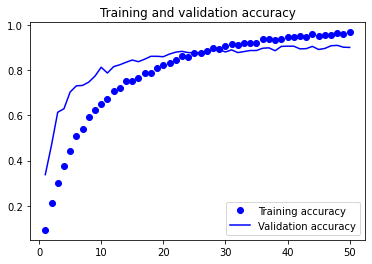

In [61]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

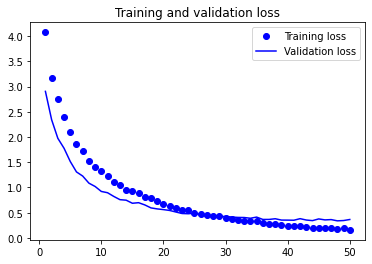

In [62]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()